# Code Summary
#### Purpose of this notebook
This notebook analyses the metrics that were calculated in the Processing_Metric.ipynb file.

The script is organised as follows:
- loading the datasets
- loading the Nino3.4 index (and processing it for further use)
- calculating correlations + linear dependence between metrics and nino3.4 index
- calculating composite images of eddy ratio during different el Nino and la Nina events
- plotting


In [1]:
#modules for datasets
import xarray as xr
from datetime import timedelta as delta

#modules for numerical support
import numpy as np
import pandas as pd

#modules for specific scientific operations
import scipy.odr as odr
from scipy.stats import pearsonr

#modules for plotting 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Loading in the datasets

In [2]:
#Load metrics
metrics = ["displacement","traveldistance","distanceratio","loopiness"]
particletype = "depth"
lenX,lenY = 291,61

data_0 = xr.open_dataset("dFAD_" + metrics[0] + "_" + particletype + "_raw.nc")
data_1 = xr.open_dataset("dFAD_" + metrics[1] + "_" + particletype + "_raw.nc")
data_2 = xr.open_dataset("dFAD_" + metrics[2] + "_" + particletype + "_raw.nc")
data_3 = xr.open_dataset("dFAD_" + metrics[3] + "_" + particletype + "_raw.nc")

In [3]:
t = data_0['releasetime'].values

displ = data_0['displacement'].values #displacement
travl = data_1['traveldistance'].values #travel distance
ratio = data_2['distanceratio'].values #distance ratio
loopi = data_3['loopiness'].values #loopiness

#Put values into pandas dataframe and take monthly mean
df_displ = pd.DataFrame(np.array(displ), index=t)
df_displ = df_displ.groupby(pd.PeriodIndex(df_displ.index, freq="M")).mean()
df_travl = pd.DataFrame(np.array(travl), index=t)
df_travl = df_travl.groupby(pd.PeriodIndex(df_travl.index, freq="M")).mean()
df_ratio = pd.DataFrame(np.array(ratio), index=t)
df_ratio = df_ratio.groupby(pd.PeriodIndex(df_ratio.index, freq="M")).mean()
df_loopi = pd.DataFrame(np.array(loopi), index=t)
df_loopi = df_loopi.groupby(pd.PeriodIndex(df_loopi.index, freq="M")).mean()

In [4]:
ENSO34_fulldata = np.genfromtxt('nina34.data', skip_header = 3,skip_footer = 4)
ENSO34_fulldata = ENSO34_fulldata - np.mean(ENSO34_fulldata[42:,],axis = 0)
ENSO34_fulldata[:,0] += 2006.5 
ENSO34_month=np.reshape(ENSO34_fulldata[56:,1:], -1)[10:-6] #will be used for correlations


ENSO34_month_prior=np.reshape(ENSO34_fulldata[56:,1:], -1)[9:-7]
ENSO34_month_later=np.reshape(ENSO34_fulldata[56:,1:], -1)[11:-5]

ONI = (ENSO34_month + ENSO34_month_prior + ENSO34_month_later)/3 #will be used to define nino events

#### Calculating mean values

In [5]:
mean_displ = np.reshape(df_displ.mean().values, (lenX,lenY))
mean_loopi = np.reshape(df_loopi.mean().values, (lenX,lenY))
mean_ratio = np.reshape(df_ratio.mean().values, (lenX,lenY))

#### Masking el Nino and la Nina events

In [6]:
#When is an ENSO event occuring?
T_Nino = np.where(ONI > 0.5)[0]
T_Nina = np.where(ONI < -0.5)[0]

mask_T_Nino =np.zeros(len(T_Nino),dtype = bool)
mask_T_Nina =np.zeros(len(T_Nina),dtype = bool)

for i in range (0,len(T_Nino)-4):
    if T_Nino[i+4] == T_Nino[i]+4:
        mask_T_Nino[i:i+5] = [True,True,True,True,True]

for i in range (0,len(T_Nina)-4):
    if T_Nina[i+4] == T_Nina[i]+4:
        mask_T_Nina[i:i+5] = [True,True,True,True,True]

Nino_event_index = T_Nino[mask_T_Nino]
Nina_event_index = T_Nina[mask_T_Nina]


Nino_event_index
Nino2009 = [33,  34,  35,  36,  37,  38,  39,  40]
Nino2015 = [95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
Nino2018 = [142, 143, 144, 145, 146, 147, 148, 149, 150]

In [7]:
ratio_nino = df_ratio.iloc[Nino_event_index].mean()
ratio_nino2009 = df_ratio.iloc[Nino2009].mean()
ratio_nino2015 = df_ratio.iloc[Nino2015].mean()
ratio_nino2018 = df_ratio.iloc[Nino2018].mean()
ratio_nina = df_ratio.iloc[Nina_event_index].mean()

In [8]:
ratio_nino = np.reshape(ratio_nino.values, (lenX,lenY))
ratio_nino2009 = np.reshape(ratio_nino2009.values, (lenX,lenY))
ratio_nino2015 = np.reshape(ratio_nino2015.values, (lenX,lenY))
ratio_nino2018 = np.reshape(ratio_nino2018.values, (lenX,lenY))
ratio_nina = np.reshape(ratio_nina.values, (lenX,lenY))

#### Calculating correlations w.r.t. ENSO

In [9]:
#Calculating pearson correlations and significance
N = lenX*lenY
r_displ = np.zeros([N,2])
r_travl = np.zeros([N,2])
r_ratio = np.zeros([N,2])
r_loopi = np.zeros([N,2])

for pc in range(N):
    if np.sum(df_displ[pc]>-999) == 176:
        r_displ[pc] = pearsonr(ENSO34_month,df_displ[pc])
    if np.sum(df_travl[pc]>-999) == 176:
        r_travl[pc] = pearsonr(ENSO34_month,df_travl[pc])
    if np.sum(df_ratio[pc]>-999) == 176:
        r_ratio[pc] = pearsonr(ENSO34_month,df_ratio[pc])
    if np.sum(df_loopi[pc]>-999) == 176:
        r_loopi[pc] = pearsonr(ENSO34_month,df_loopi[pc])

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [10]:
p_displ = np.reshape(r_displ[:,1], (lenX,lenY))
r_displ = np.reshape(r_displ[:,0], (lenX,lenY))
p_travl = np.reshape(r_travl[:,1], (lenX,lenY))
r_travl = np.reshape(r_travl[:,0], (lenX,lenY))
p_ratio = np.reshape(r_ratio[:,1], (lenX,lenY))
r_ratio = np.reshape(r_ratio[:,0], (lenX,lenY))
p_loopi = np.reshape(r_loopi[:,1], (lenX,lenY))
r_loopi = np.reshape(r_loopi[:,0], (lenX,lenY))

#### Calculating regression coefficients

In [11]:
beta = np.zeros([3,N]) #linear regression coefficient (slope)
beta_sigma = np.zeros([3,N]) #uncertainty of linear regression coefficient (slope)
A_start=200
B_start=10

#function for linear fit
def f(B, x):
    return B[0] + B[1]*x

#ODR calculation
for j in range(3): #for every metric
    if j == 0:
        metricdata = df_displ
    elif j == 1:
        metricdata = df_ratio
    else:
        metricdata = df_loopi
        
    for i in range(N):
        y = metricdata[i].values
        x = ENSO34_month
        sig_y = np.ones(len(ENSO34_month))

        odr_model = odr.Model(f)
        odr_data  = odr.RealData(x,y,sy=sig_y)
        odr_obj   = odr.ODR(odr_data,odr_model,beta0=[A_start,B_start])
        odr_obj.set_job(fit_type=2)
        odr_res   = odr_obj.run()
        par_best = odr_res.beta
        par_sig_ext = odr_res.sd_beta #externe onzekerheid
        beta[j,i] = par_best[1]
        beta_sigma[j,i] = par_sig_ext[1]

In [12]:
reg_displ = np.reshape(beta[0,:], (lenX,lenY))
reg_ratio = np.reshape(beta[1,:], (lenX,lenY))
reg_loopi = np.reshape(beta[2,:], (lenX,lenY))

regsig_displ = np.reshape(beta_sigma[0,:], (lenX,lenY))
regsig_ratio = np.reshape(beta_sigma[1,:], (lenX,lenY))
regsig_loopi = np.reshape(beta_sigma[2,:], (lenX,lenY))

In [13]:
xmin,xmax = 140, 285 #minimum/maximum longitude (285 = 75deg West)
ymin,ymax = -15, 15  #minimum/maximum latitude

c_lon = 165          #central longitude (variable used to plot between 180deg East and 180deg West)
xten = xmin - c_lon  #variable for plotting (minimum longitude)
xten2 = xmax- c_lon  #variable for plotting (maximum longitude)

lonEEZ = np.linspace(xmin-c_lon,xmax-c_lon,num = lenX)
latEEZ = np.linspace(ymin,ymax, num = lenY)
#lonEEZ[lonEEZ>180] += -360
XX,YY = np.meshgrid(lonEEZ,latEEZ)
#Function for plotting correlation/linear regression in the Tropical Pacific Ocean with significance of correlation
#Very Similar to valueplot function
def correlationplot(data, p_value, value_lim = [-np.pi/2,np.pi/2], title = "", xlabel = 'longitude (degrees)', ylabel = 'latitude (degrees)',list_ticks =[0],names_ticks=['0'], clabel = "r", color ='bwr'):
    fig = plt.figure(figsize=(9,5),constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=165))

    axpos = ax.get_position()
    pos_x = 3*axpos.x0 +0.11
    pos_y = axpos.y0 +0.185
    cax_width = 0.02
    cax_height = axpos.height/2
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.xticks(rotation=45)
    ax.set_title(title, fontsize = 16)
    plt.rc('font', size=15)
    plt.rc('axes', titlesize=15)
    ax.add_feature(cfeature.COASTLINE)
    im = ax.imshow(data.T, origin ='lower',vmin= value_lim[0],vmax=value_lim[1] ,extent = [xten,xten2, ymin,ymax], cmap = color)
    im2 = ax.contour(XX,YY,1 - p_value.T, levels = [0.95],colors = 'k',linestyles = 'dashed')   #Plotting Statistical significance of correlation
   
    if len(list_ticks) > 1:
        cbar = fig.colorbar(im ,cax=pos_cax, extend = 'both', ticks = list_ticks)
        cbar.ax.set_yticklabels(names_ticks)  
    else:
        cbar = fig.colorbar(im ,cax=pos_cax, extend = 'both')
        
    cbar.set_label(clabel, rotation=270, labelpad = 20, fontsize = 15)
    plt.plot(1000,1001, 'k--', label = 'p = 0.95') #Workaround to make stat. signif. in legend
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    plt.legend(loc = 'best',bbox_to_anchor=(-.6,1))
    
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([120,140,160,180,-160,-140,-120,-100,-80])
    gl.ylocator = mticker.FixedLocator([30,20,10,0,-10,-20,-30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
def valueplot(data, value_lim = None, title = "", xlabel = 'longitude (degrees)', ext = 'max',ylabel = 'latitude (degrees)',list_ticks =[0],names_ticks=['0'], clabel = "", color = 'BuPu_r'):
    #Generate Figure
    fig = plt.figure(figsize=(9,5),constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=c_lon))

    #Set location for colorbar
    axpos = ax.get_position()
    pos_x = 3*axpos.x0 +0.11
    pos_y = axpos.y0 +0.185
    cax_width = 0.02
    cax_height = axpos.height/2
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

    #Set labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.xticks(rotation=45)
    ax.set_title(title, fontsize = 16)
    plt.rc('font', size=15)
    plt.rc('axes', titlesize=15)
    ax.add_feature(cfeature.COASTLINE)
    
    #Plotting Values
    if value_lim == None: #No boundaries for values are given, let imshow decide.
        im = ax.imshow(data.T,origin ='lower', extent = [xten,xten2, ymin,ymax], cmap = color)
    else: #Boundaries are imposed
        im = ax.imshow(data.T,origin ='lower',vmin= value_lim[0],vmax=value_lim[1], extent = [xten,xten2, ymin,ymax], cmap = color)
    
    #Custom tick labels (e.g. $\pi$ instead of 3.1415)
    if len(list_ticks) > 1:
        cbar = fig.colorbar(im ,cax=pos_cax, extend = ext, ticks = list_ticks)
        cbar.ax.set_yticklabels(names_ticks)
    else: #No custom tick labels
        cbar = fig.colorbar(im ,cax=pos_cax, extend = ext)
    
    #Setting Grid/Ticks
    cbar.set_label(clabel, rotation=270, labelpad = 20, fontsize = 15)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([120,140,160,180,-160,-140,-120,-100,-80])
    gl.ylocator = mticker.FixedLocator([30,20,10,0,-10,-20,-30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

#### Plotting Mean Values

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


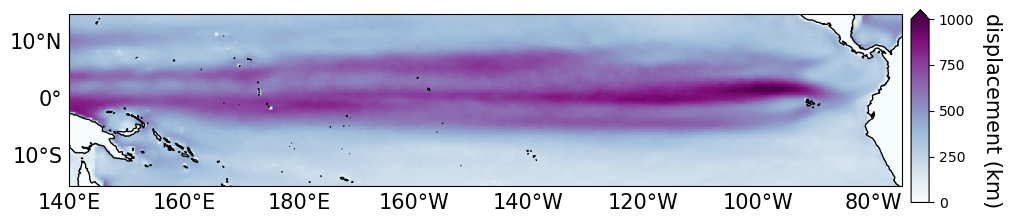

In [14]:
plot_path = 'C:/Users/FrankemollePFVW/OneDrive - University of Twente/PublicationMastersThesis/Figures/Figures_v2/'
metric = metrics[0]
valueplot(mean_displ, clabel = "displacement (km)", value_lim =[0,1000],color = 'BuPu')
plt.savefig(plot_path + particletype + '/mean_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


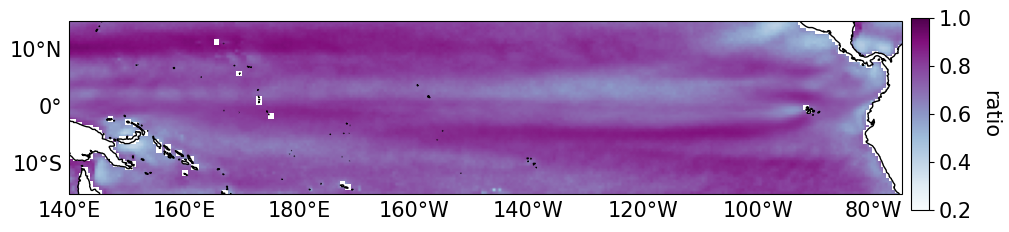

In [15]:
plot_path = 'C:/Users/FrankemollePFVW/OneDrive - University of Twente/PublicationMastersThesis/Figures/Figures_v2/'
metric = metrics[2]
valueplot(mean_ratio, clabel = "ratio", value_lim =[0.2,1],color = 'BuPu', ext = 'neither')
plt.savefig(plot_path + particletype + '/mean_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


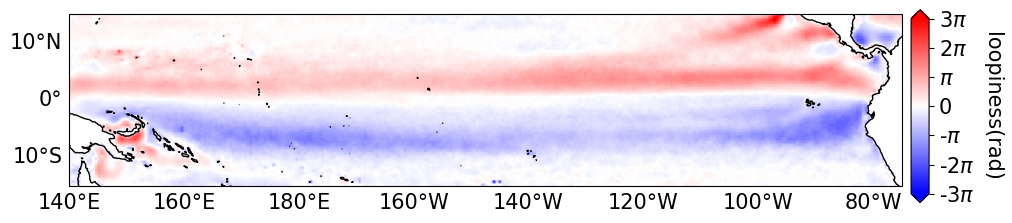

In [18]:
plot_path = 'C:/Users/FrankemollePFVW/OneDrive - University of Twente/PublicationMastersThesis/Figures/Figures_v2/'
metric = metrics[3]
pi = np.pi
valueplot(mean_loopi, clabel = "loopiness(rad)",value_lim = [-3*pi,3*pi],color = 'bwr', list_ticks = [-3*pi,-2*pi,-pi, 0,pi,2*pi,3*pi], ext = 'both',names_ticks = [r'-3$\pi$',r'-2$\pi$',r'-$\pi$','0',r'$\pi$',r'2$\pi$',r'3$\pi$'])
plt.savefig(plot_path + particletype + '/mean_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

#### Plotting Correlations

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


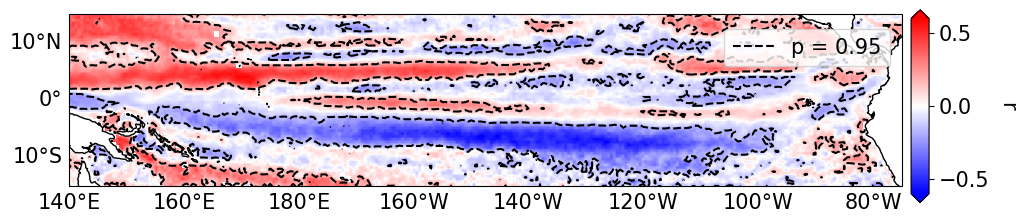

In [19]:
#correlationplots
plot_path = 'C:/Users/FrankemollePFVW/OneDrive - University of Twente/PublicationMastersThesis/Figures/Figures_v2/'
metric = metrics[0]

correlationplot(r_displ, p_displ, value_lim = [-.6,.6], 
    xlabel = 'longitude (degrees)', ylabel = 'latitude [degrees]', clabel = "r")
plt.savefig(plot_path + particletype + '/correlation_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


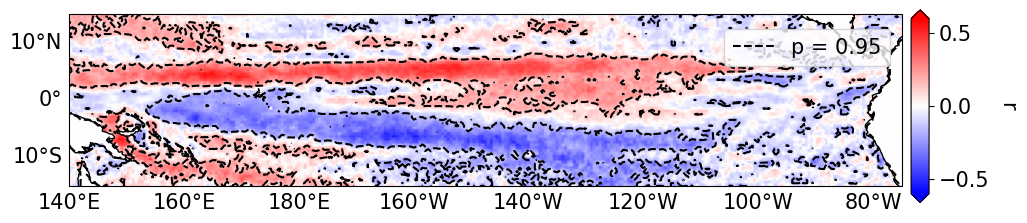

In [20]:
metric = metrics[2]

correlationplot(r_ratio, p_ratio, value_lim = [-.6,.6], 
    xlabel = 'longitude (degrees)', ylabel = 'latitude [degrees]', clabel = "r")
plt.savefig(plot_path + particletype + '/correlation_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


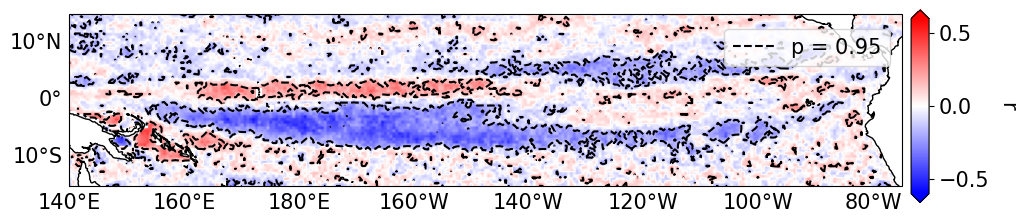

In [21]:
metric = metrics[3]

correlationplot(r_loopi, p_loopi, value_lim = [-.6,.6], 
    xlabel = 'longitude (degrees)', ylabel = 'latitude [degrees]', clabel = "r")
plt.savefig(plot_path + particletype + '/correlation_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

#### Plotting regression coefficients

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


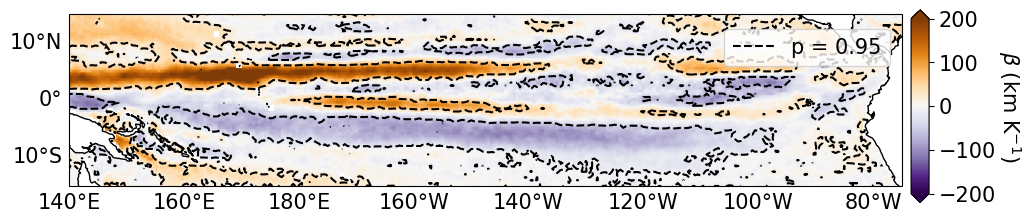

In [22]:
metric = metrics[0]

correlationplot(reg_displ, p_displ, value_lim = [-200,200],
    xlabel = 'longitude (degrees)', ylabel = 'latitude (degrees)', clabel = r"$\beta$ (km K$^{-1}$)", color = 'PuOr_r')
plt.savefig(plot_path + particletype + '/linearregression_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


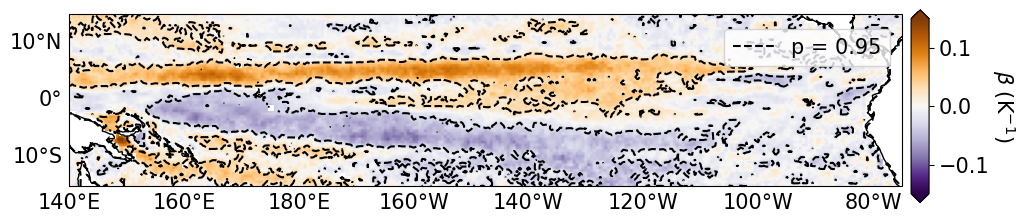

In [23]:
metric = metrics[2]

correlationplot(reg_ratio, p_ratio,value_lim = [-.15,.15],
    xlabel = 'longitude (degrees)', ylabel = 'latitude (degrees)', clabel = r"$\beta$ (K$^{-1}$)", color = 'PuOr_r')
plt.savefig(plot_path + particletype + '/linearregression_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


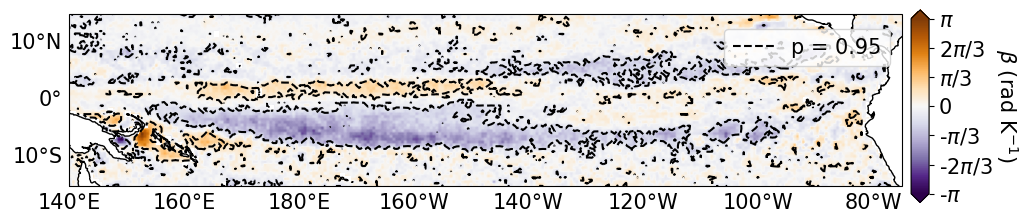

In [24]:
metric = metrics[3]
pi = np.pi
correlationplot(reg_loopi, p_loopi,value_lim = [-np.pi,np.pi],
     list_ticks = [-pi,-2*pi/3,-pi/3, 0,pi/3,2*pi/3,pi], names_ticks = [r'-$\pi$',r'-2$\pi$/3',r'-$\pi$/3','0',r'$\pi$/3',r'2$\pi$/3',r'$\pi$'],            
     xlabel = 'longitude (degrees)', ylabel = 'latitude (degrees)', clabel = r"$\beta$ (rad K$^{-1}$)", color = 'PuOr_r')
plt.savefig(plot_path + particletype + '/linearregression_' + metric + '_'+ particletype+ '.pdf', bbox_inches='tight')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


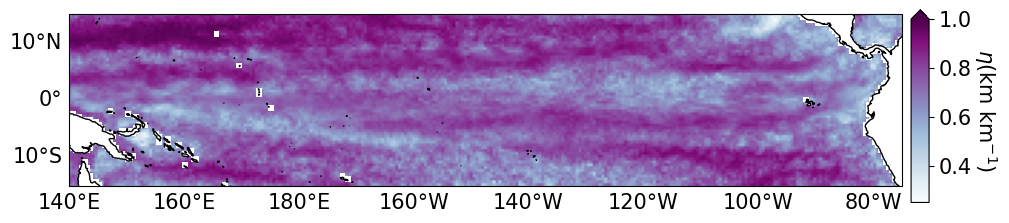

In [25]:
valueplot(ratio_nino2009, clabel = r"$\eta$(km km$^{-1}$)", value_lim = [0.25,1],color = 'BuPu')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


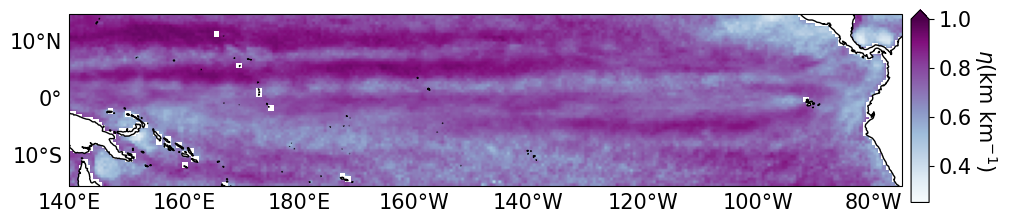

In [26]:
valueplot(ratio_nino2015, clabel = r"$\eta$(km km$^{-1}$)", value_lim = [0.25,1],color = 'BuPu')

C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\FrankemollePFVW\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


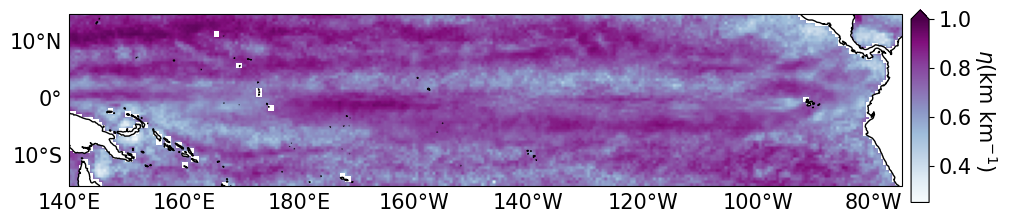

In [27]:
valueplot(ratio_nino2018, clabel = r"$\eta$(km km$^{-1}$)", value_lim = [0.25,1],color = 'BuPu')

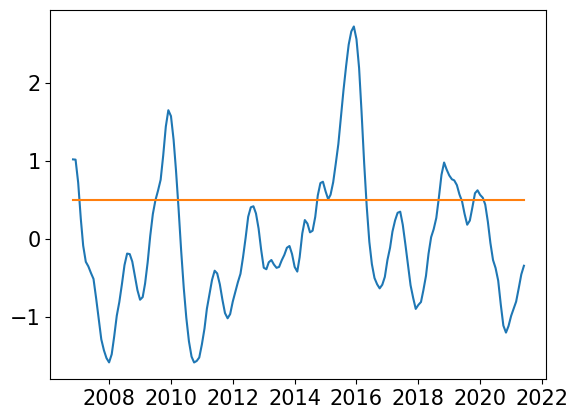

In [28]:
timee = df_displ.index.astype('datetime64[ns]').values
plt.plot(timee,ONI)
plt.plot([timee[0],timee[-1]],[0.5,0.5])